In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files   # Download kaggle.json
files.upload()

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/tomato-detection

 97% 174M/180M [00:01<00:00, 75.1MB/s]
100% 180M/180M [00:01<00:00, 112MB/s] 


In [ ]:
!unzip tomato-detection.zip -d ./ && rm tomato-detection.zip

In [5]:
### clone yolov5
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12530, done.
remote: Total 12530 (delta 0), reused 0 (delta 0), pack-reused 12530
Receiving objects: 100% (12530/12530), 11.62 MiB | 25.32 MiB/s, done.
Resolving deltas: 100% (8727/8727), done.


In [6]:
!pip install -qr yolov5/requirements.txt

     |████████████████████████████████| 596 kB 5.3 MB/s eta 0:00:01


In [7]:
import torch
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import os
import random
from datetime import datetime
from xml.etree import ElementTree as ET

In [8]:
print('Number of images:', len(os.listdir('images')))
print('Number of annotations:', len(os.listdir('annotations')))

Number of images: 895
Number of annotations: 895


In [9]:
images = sorted(os.listdir('images'))
labels = sorted(os.listdir('annotations'))

correct = 0

for path_img, path_annot in zip(images, labels):
    name_img = '.'.join(path_img.split('.')[:-1])
    name_annot = '.'.join(path_img.split('.')[:-1])

    if name_img == name_annot:
        correct += 1

if len(images) == len(labels) == correct:
    print('Everything is fine!')
else:
    print('Incorrect!')

Everything is fine!


In [10]:
annotations = {
    'name': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}

In [11]:
for name_file in os.listdir('annotations'):
    full_path = os.path.join('annotations', name_file)
    tree = ET.parse(full_path).getroot()
    
    name = '.'.join(name_file.split('.')[:-1])
    width = int(tree.find('size').find('width').text)
    height = int(tree.find('size').find('height').text)

    for obj in tree.findall('object'):
        class_ = obj.find('name').text
        bndbox = obj.find('bndbox')

        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        annotations['name'].append(name)
        annotations['width'].append(width)
        annotations['height'].append(height)
        annotations['class'].append(class_)
        
        annotations['xmin'].append(xmin)
        annotations['ymin'].append(ymin)
        annotations['xmax'].append(xmax)
        annotations['ymax'].append(ymax)


In [12]:
dataset = pd.DataFrame(annotations)

In [13]:
dataset[['name', 'width', 'height']].drop_duplicates()[['width', 'height']].value_counts()

width  height
400    500       545
500    400       350
dtype: int64

In [ ]:
########## prepare images

In [14]:
def show_image(df, count=5, resize=None):
    plt.figure(figsize=(8, 8 * count))
    
    for idx_plot in range(count):
        name_file = random.choice(df['name'].unique())
        data = df[df.name == name_file]

        img_path = os.path.join('images', name_file + '.png')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if resize:
            image = cv2.resize(image, (resize), interpolation=cv2.INTER_LINEAR)

        if str(type(data)) == "<class 'pandas.core.series.Series'>":
            data = pd.DataFrame(data).T     # to make iterrows work

        for row in data.iterrows():
            row = row[1]
            cv2.rectangle(image,
                          (int(row['xmin']), int(row['ymin'])),
                          (int(row['xmax']), int(row['ymax'])),
                          (0, 255, 0),
                          cv2.LINE_4, 1)

        plt.subplot(count, 1, idx_plot + 1)
        plt.imshow(image)

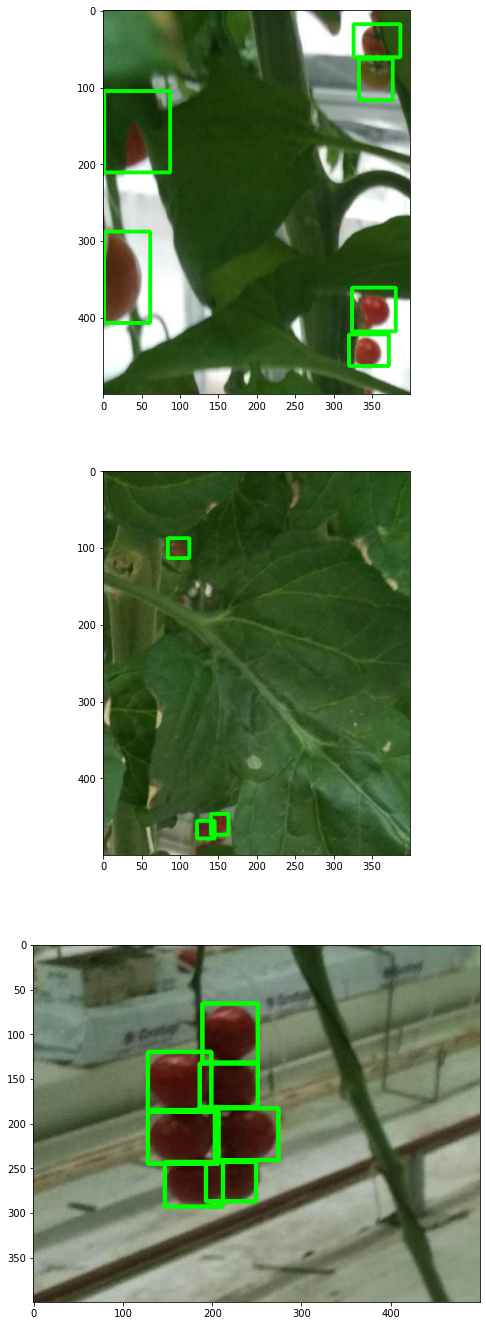

In [15]:
show_image(dataset, 3)

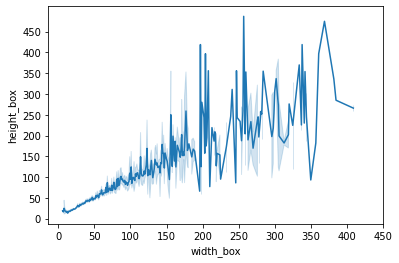

In [16]:
width_box = dataset['xmax'] - dataset['xmin']
height_box = dataset['ymax'] - dataset['ymin']

shape_box = list(tuple(zip(width_box, height_box)))
shape_box.sort(key=lambda x: x[0])

width_box = [obj[0] for obj in shape_box]
height_box = [obj[1] for obj in shape_box]

sns.lineplot(x=width_box, y=height_box)  ## they is crumpled sometimes
plt.xticks(range(0, max(height_box) + 1, 50))
plt.yticks(range(0, max(height_box) + 1, 50))
plt.xlabel('width_box')
plt.ylabel('height_box');

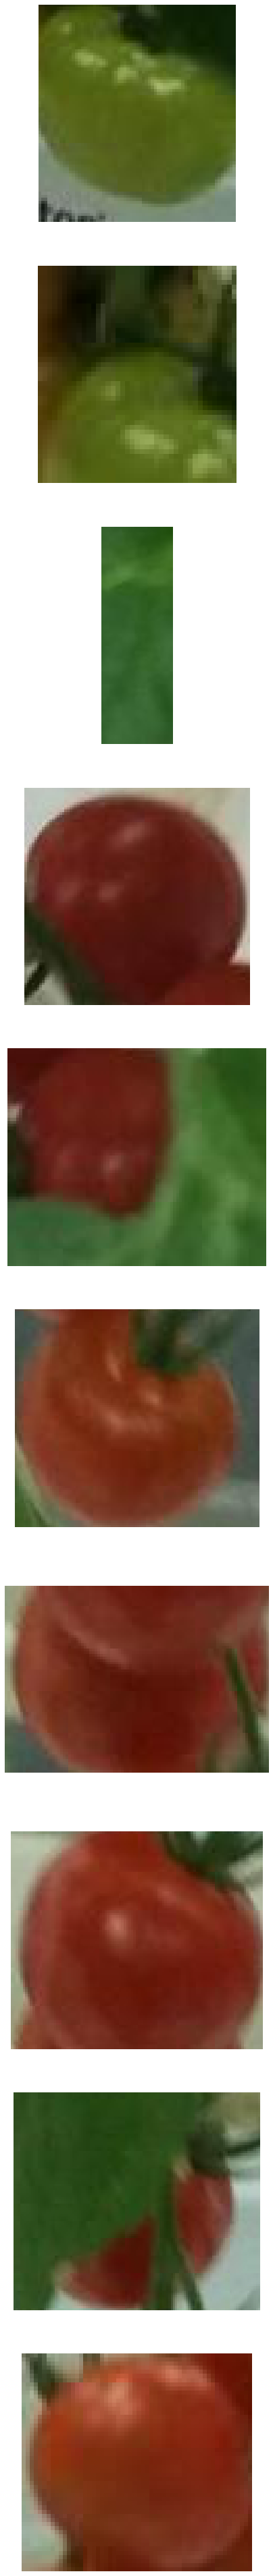

In [17]:
red = []
green = []

plt.figure(figsize=(7, 7 * 10))
ita = 0

for name in os.listdir('images'):
    data = dataset[dataset.name + '.png' == name]
    path = os.path.join('images', name)
    image = cv2.imread(path)
    
    if str(type(data)) == "<class 'pandas.core.series.Series'>":
        data = pd.DataFrame(data).T     # to make iterrows work

    for row in data.iterrows():
        row = row[1]
        box = image[row['ymin']:row['ymax'], row['xmin']:row['xmax'], :]   # check intensity for every boxes

        if ita < 10:
            plt.subplot(10, 1, ita + 1)
            plt.imshow(cv2.cvtColor(box, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            ita += 1

        red.append(box[:, :, 2].sum())
        green.append(box[:, :, 1].sum())

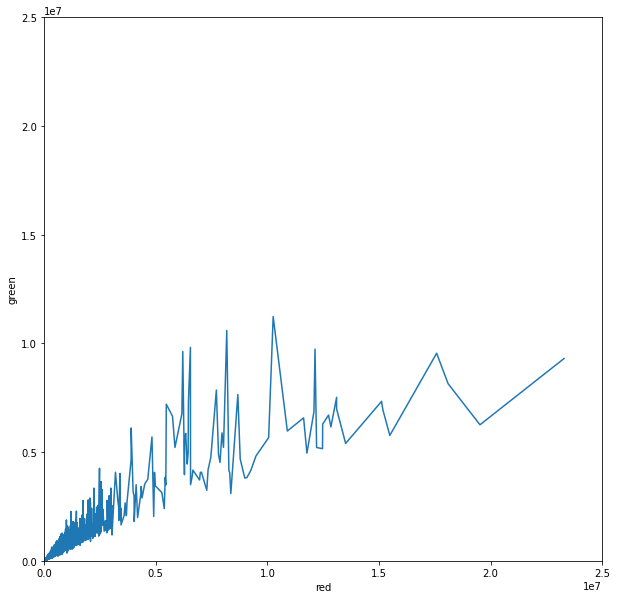

In [18]:
red_green = list(tuple(zip(red, green)))
red_green.sort(key=lambda x: x[0])

red = [obj[0] for obj in red_green]
green = [obj[1] for obj in red_green]

plt.figure(figsize=(10, 10))
sns.lineplot(x=red, y=green)        #  tomatoes are mostly red
plt.xlim(0, 1e7 * 2.5)
plt.ylim(0, 1e7 * 2.5)
plt.xlabel('red')
plt.ylabel('green');

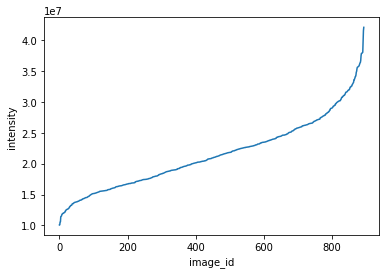

In [19]:
intensity = []

for name in os.listdir('images'):
    path = os.path.join('images', name)
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    intensity.append(image.sum())

sns.lineplot(x=range(len(intensity)), y=sorted(intensity))       #  no black images
plt.xlabel('image_id')
plt.ylabel('intensity');

In [20]:
os.mkdir('yolov5/data/train')
os.mkdir('yolov5/data/val')
os.mkdir('yolov5/data/test')

os.mkdir('yolov5/data/train/images')
os.mkdir('yolov5/data/train/labels')
os.mkdir('yolov5/data/val/images')
os.mkdir('yolov5/data/val/labels')
os.mkdir('yolov5/data/test/images')
os.mkdir('yolov5/data/test/labels')

In [21]:
names = dataset['name'].unique()

train, holdout = train_test_split(names, test_size=0.3)
val, test = train_test_split(holdout, test_size=0.4)

print('Train length:', len(train))
print('Val length:', len(val))
print('Test length:', len(test))

Train length: 626
Val length: 161
Test length: 108


In [22]:
new_width = 400
new_height = 500

In [23]:
def copy_images(list_of_files, path, size):
    for name_file in list_of_files:
        name_file = name_file + '.png'
        img = cv2.imread(os.path.join('images', name_file))
        img = cv2.resize(img, (size), interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(f'{path}/{name_file}', img)


In [24]:
copy_images(train, 'yolov5/data/train/images', (new_width, new_height))
copy_images(val, 'yolov5/data/val/images', (new_width, new_height))
copy_images(test, 'yolov5/data/test/images', (new_width, new_height))

In [25]:
dataset['class'] = 1

In [26]:
dataset['xmin'] = (new_width / dataset['width']) * dataset['xmin']
dataset['xmax'] = (new_width / dataset['width']) * dataset['xmax']    # change the box relative to the new dimension
dataset['ymin'] = (new_height / dataset['height']) * dataset['ymin']
dataset['ymax'] = (new_height / dataset['height']) * dataset['ymax'] 

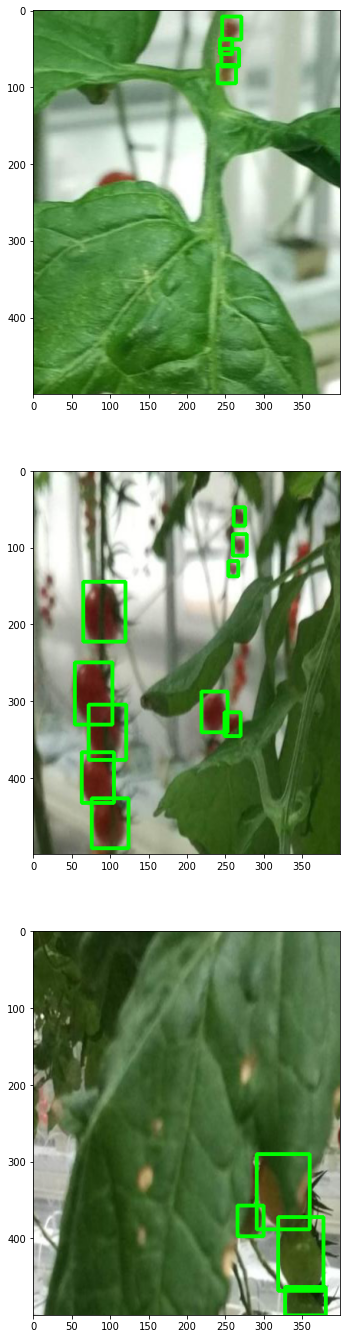

In [27]:
show_image(dataset, 3, resize=(400, 500))

In [28]:
dataset['xmin'] = dataset['xmin'] / new_width
dataset['xmax'] = dataset['xmax'] / new_width      # regarding the parties
dataset['ymin'] = dataset['ymin'] / new_height
dataset['ymax'] = dataset['ymax'] / new_height

dataset['width_box'] = dataset['xmax'] - dataset['xmin']
dataset['height_box'] = dataset['ymax'] - dataset['ymin']

dataset['x_center'] = dataset['width_box'] / 2 + dataset['xmin']
dataset['y_center'] = dataset['height_box'] / 2 + dataset['ymin']

In [29]:
dataset = dataset.astype('string')

In [30]:
dataset.head()

,name,width,height,class,xmin,ymin,xmax,ymax,width_box,height_box,x_center,y_center
0,tomato744,400,500,1,0.15,0.576,0.2425,0.65,0.0925,0.07400000000000007,0.19624999999999998,0.613
1,tomato744,400,500,1,0.1325,0.502,0.235,0.588,0.10249999999999998,0.08599999999999997,0.18375,0.5449999999999999
2,tomato744,400,500,1,0.225,0.48,0.3225,0.562,0.0975,0.08200000000000007,0.27375,0.521
3,tomato744,400,500,1,0.1775,0.42,0.275,0.498,0.09750000000000003,0.07800000000000001,0.22625,0.45899999999999996
4,tomato744,400,500,1,0.2525,0.398,0.345,0.472,0.09249999999999997,0.07399999999999995,0.29874999999999996,0.435


In [31]:
def copy_labels(list_of_files, path, df):
    for name_file in list_of_files:
        data = df[df.name == name_file]
        boxes = []

        if str(type(data)) == "<class 'pandas.core.series.Series'>":
            data = pd.DataFrame(data).T     # to make iterrows work
        
        for row in data.iterrows():
            row = row[1]
            boxes.append(f"{row['class']} {row['x_center']} {row['y_center']} {row['width_box']} {row['height_box']}")

        labels = '\n'.join(boxes)
        
        with open(f"{path}/{name_file}.txt", 'w') as f:
            f.write(labels)

In [32]:
copy_labels(train, 'yolov5/data/train/labels', dataset)
copy_labels(val, 'yolov5/data/val/labels', dataset)
copy_labels(test, 'yolov5/data/test/labels', dataset)

In [33]:
%cd yolov5

/content/yolov5


In [34]:
data_config = '''
train: data/train/images
val: data/val/images

nc: 1
names: ['tomato']'''

with open('data/data.yaml', 'w') as f:
    f.write(data_config)

In [35]:
model_config = '''
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]'''


with open('models/model_s.yaml', 'w') as f:
    f.write(model_config)

In [37]:
start = datetime.now()
!python3 train.py --data data/data.yaml --cfg models/model_s.yaml --epochs 50 --batch-size 12 --weights '' --cache --device 0 --single-cls
end = datetime.now()

train: weights=, cfg=models/model_s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=12, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=True, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-105-gd257c75 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.

In [38]:
!mv runs/train/exp/weights/best.pt "/content/drive/MyDrive/My_pth-s"

In [39]:
!python3 detect.py --source /content/yolov5/data/test/images --weights /content/drive/MyDrive/My_pth-s/best.pt --name detect_s50ep --save-txt

detect: weights=['/content/drive/MyDrive/My_pth-s/best.pt'], source=/content/yolov5/data/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=detect_s50ep, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-105-gd257c75 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
model_s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/108 /content/yolov5/data/test/images/tomato107.png: 640x512 2 tomatos, Done. (0.030s)
image 2/108 /content/yolov5/data/test/images/tomato118.png: 640x512 15 tomatos, Done. (0.030s)
image 3/108 /content/yolov5/data/test/images/tomato121.png: 640x512 2 tomatos, Done. (0.030s)
image 4/108 /content/yolov5/data/test/images/tomato134.png

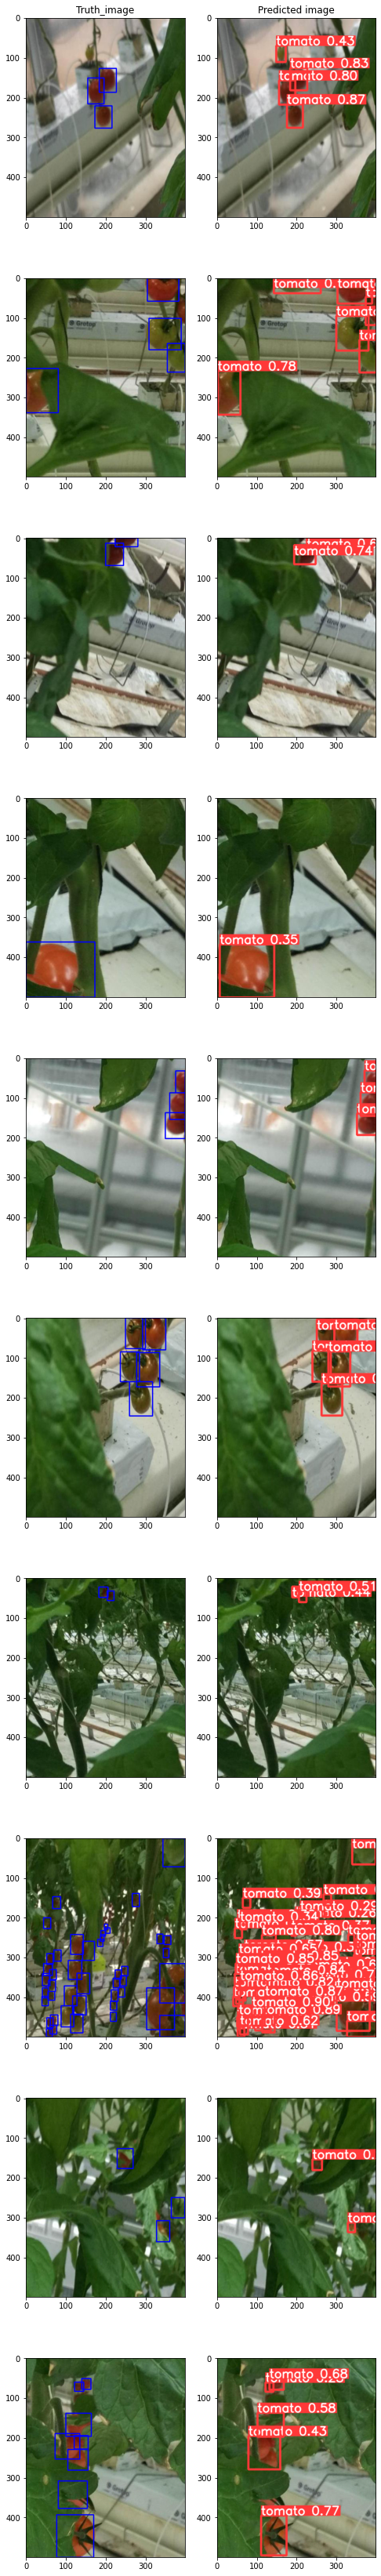

In [40]:
fig, axes = plt.subplots(10, 2, figsize=(8, 60))

for i in range(10):
    name = random.choice(test)

    detect_img_dir = os.path.join('runs/detect/detect_s50ep', name + '.png') 
    image_predicted = cv2.imread(detect_img_dir)
    image_predicted = cv2.cvtColor(image_predicted, cv2.COLOR_BGR2RGB)


    truth_img = cv2.imread(os.path.join('data/test/images', name + '.png'))
    truth_data = dataset[dataset.name == name]

    for idx in range(len(truth_data)):
        try:
            row = truth_data.iloc[idx]
        except:
            row = truth_data

        xmin = int(float(row['xmin']) * new_width)  # 400
        xmax = int(float(row['xmax']) * new_width)
        ymin = int(float(row['ymin']) * new_height)
        ymax = int(float(row['ymax']) * new_height)

        cv2.rectangle(truth_img,
                      (xmin, ymin),
                      (xmax, ymax),
                      (255, 0, 0), 2, cv2.LINE_4)
        
    truth_img = cv2.cvtColor(truth_img, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(truth_img)
    axes[i, 1].imshow(image_predicted)

    if i == 0:
        axes[i, 0].set_title('Truth_image')
        axes[i, 1].set_title('Predicted image')